In this notebook we study the variability in the target spectra with tilt and the variability in the compensated Target Strength

In [1]:
import time
import os.path
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
from tenacity import retry, stop_after_attempt
import glob
import scipy as sc
import csaps

import sys, errno  


In [2]:

palette = sns.color_palette('colorblind')
plt.style.use(['seaborn-colorblind'])
plt.rc('font', family='Arial')
SMALL_SIZE = 12
BIGGER_SIZE = 14
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True
plt.rcParams['xtick.direction'] = 'inout'
plt.rcParams['ytick.direction'] = 'inout'
plt.rcParams['xtick.major.size'] = 5
plt.rcParams['xtick.minor.size'] = 3
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['ytick.major.size'] = 5
plt.rcParams['ytick.minor.size'] = 3
plt.rcParams['ytick.major.width'] = 1

savefigs_path = 'C:/Users/mbd/OneDrive - Akvaplan-niva AS/PhD-APN/ChaptersandExperiments/AFKABAN'

In [3]:
# -- USER-DETERMINED PARAMETERS -----------------------------------------------
letter_drive = 'F'
ppath = f'{letter_drive}:/AFKABAN/Pcod_190123/'
p2path = f'{letter_drive}:/AFKABAN/Pcod2_240123/'
apath = f'{letter_drive}:/AFKABAN/Acod_200123/'
pbpath = f'{letter_drive}:/AFKABAN/Pandalus_260123/'


# Read saved df

In [4]:
a_df = pd.read_feather(apath+'/a_tilt_df.feather')
p_df = pd.read_feather(ppath+'/p_tilt_df.feather')
p2_df = pd.read_feather(p2path+'/p2_tilt_df.feather')
pb_df = pd.read_feather(pbpath+'/pb_tilt_df.feather')

a_df.insert(0,'peaks', np.nan)
p_df.insert(0,'peaks', np.nan)
p2_df.insert(0,'peaks', np.nan)
pb_df.insert(0,'peaks', np.nan)

### select flat or bumpy spectra

0
[41 42 43 44 45 46 47 48]
1
[527 528 529 530 531 532 533]
2
[41 42 43 44 45 46 47 48]
3
[77 78 79 80 81 82 83 84]


C:\Users\mbd\AppData\Local\Temp\ipykernel_32272\1408882859.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['peaks'].iloc[i]=n_peaks


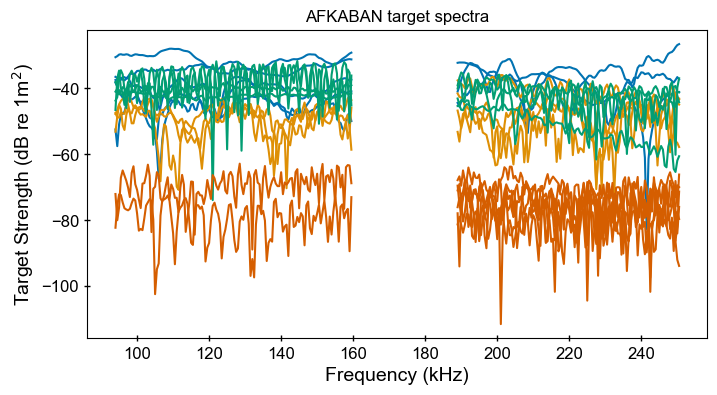

In [5]:
df_list = [a_df,p_df,p2_df,pb_df]
fig,ax = plt.subplots(1,1, figsize=(8,4))

for i_df in range(len(df_list)):
    # calculate median tilt for intervals of 10 degrees tilt
    df = df_list[i_df]
    print(i_df)
    ts_s = np.where(df.columns.values=='90.000')[0][0]
    ts_e = np.where(df.columns.values=='255.000')[0][0]
    df_ts = df.iloc[:,ts_s:ts_e+1]

    freqs = df_ts.columns.unique().values.astype(np.float64)
    
    i_region = df['Region_name'].unique()[7]
    ind = np.where(df['Region_name']== i_region)[0]
    print(ind)
    
    for i in ind:
        peaks = sc.signal.find_peaks(df_ts.iloc[i,:], prominence=10)[0]
        n_peaks = len(peaks)
        # Plot median and CI

        df['peaks'].iloc[i]=n_peaks

        ax.plot(freqs,df_ts.iloc[i,:],c=palette[i_df])

        #ax.plot(freqs[peaks], df_ts.iloc[i,peaks], 'x', c='k')

    ax.set_ylabel('Target Strength (dB re 1m$^2$)')
    ax.set_title('AFKABAN target spectra')
    ax.set_xlabel('Frequency (kHz)')

Observations:
- It seems that a threshold at -60 dB could be used to discriminate between Northen shrimp and polar or Atlantic cod. 
- High variability in broadband target spectra, largest for Atlantic cod (~10 dB)
- Both Polar cod medians follow same pattern. Atlantic cod is very similar but slight differences

### Plot distribution of tilt for all SED in tracks

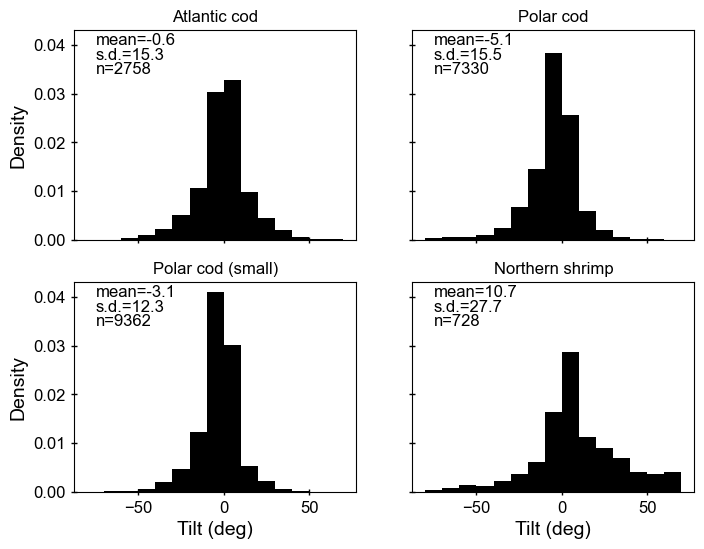

In [6]:
## set up bins
bin_array = np.arange(-80,80,10) 
fig, ax = plt.subplots(2,2, figsize=(8,6), sharex=True, sharey=True)
axes = ax.flatten()

df_list = [a_df,p_df,p2_df,pb_df]
name_list = ['Atlantic cod', 'Polar cod', 'Polar cod (small)', 'Northern shrimp']

for i_df in range(len(df_list)):
    df = df_list[i_df]
    axes[i_df].hist(df['tilt'], bins = bin_array, density=True, color='k')
    axes[i_df].set_title(name_list[i_df])
    axes[i_df].text(-75,0.04,'mean=%.1f' %np.mean(df['tilt']))
    axes[i_df].text(-75,0.037,'s.d.=%.1f' %np.std(df['tilt']))
    axes[i_df].text(-75,0.034,'n=%.0f' %(len(df['tilt'])/2))
axes[0].set_ylabel('Density')
axes[2].set_ylabel('Density')
axes[2].set_xlabel('Tilt (deg)')
axes[3].set_xlabel('Tilt (deg)');

### Variability in TS compensated across tilt

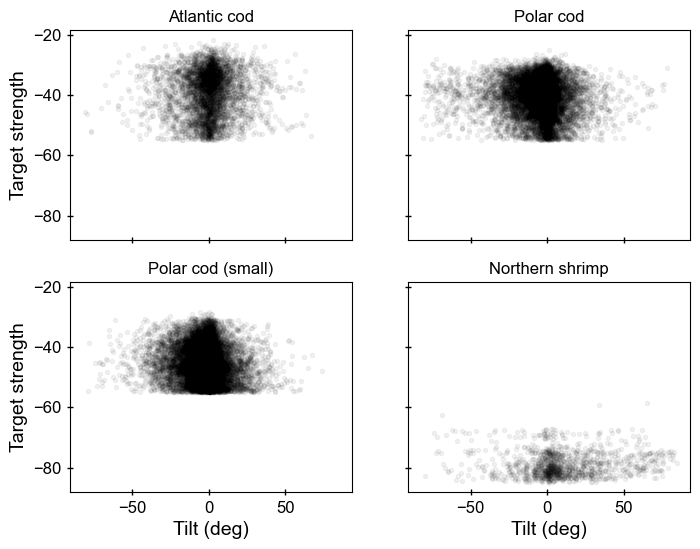

In [7]:
## set up bins
bin_array = np.arange(-80,-20,2) 
fig, ax = plt.subplots(2,2, figsize=(8,6), sharex=True, sharey=True)
axes = ax.flatten()

df_list = [a_df,p_df,p2_df,pb_df]
name_list = ['Atlantic cod', 'Polar cod', 'Polar cod (small)', 'Northern shrimp']

for i_df in range(len(df_list)):
    df = df_list[i_df]
    axes[i_df].plot(df['tilt'], df['TS_comp'], '.', color='k', alpha=0.05)
    axes[i_df].set_title(name_list[i_df])

axes[0].set_ylabel('Target strength')
axes[2].set_ylabel('Target strength')
axes[2].set_xlabel('Tilt (deg)')
axes[3].set_xlabel('Tilt (deg)');

Compensated target strength a the corresponding tilt for each tracked single echo detection.
- Sharp lower end limit to TS
- Dome like shape to the density of targets, slightly lower TS at slightly off axis frequencies for polar cod


### Variability in median TS across tracks
Is there more variability within a track or between different tracks?

Text(0.5, 0, 'Region number')

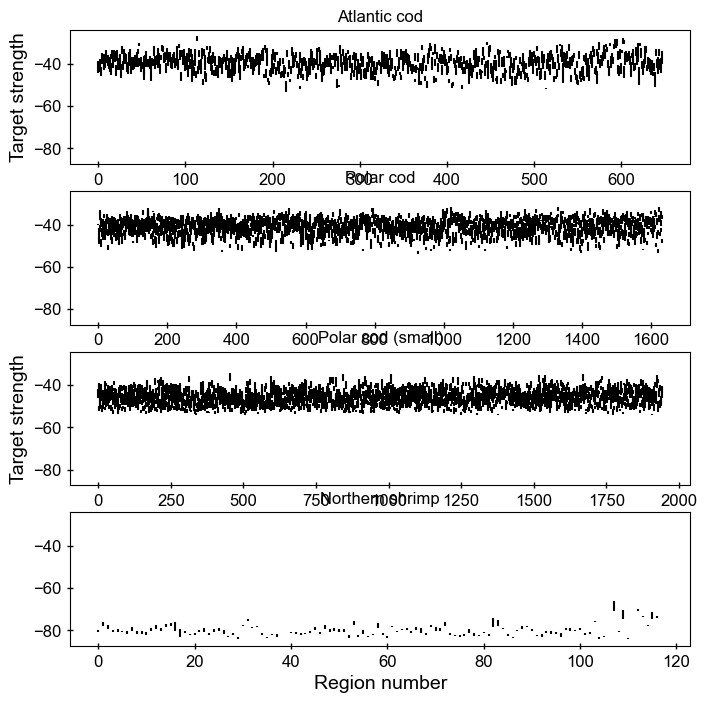

In [8]:
fig, ax = plt.subplots(4,1, figsize=(8,8), sharey=True)
axes = ax.flatten()

df_list = [a_df,p_df,p2_df,pb_df]
name_list = ['Atlantic cod', 'Polar cod', 'Polar cod (small)', 'Northern shrimp']

for i_df in range(len(df_list)):
    df = df_list[i_df]
    
    n_regions = df['Region_name'].unique()
    
    for i_region in range(len(n_regions)):

        ind_region =  df['Region_name']==n_regions[i_region]
        region_mean = np.mean(df['TS_comp'][ind_region])
        region_se = np.std(df['TS_comp'][ind_region])/np.sqrt(np.sum(ind_region))
        x_array = np.arange(len(n_regions))

        axes[i_df].errorbar(x_array[i_region],region_mean, yerr=region_se,color='k')
        #axes[i_df].fill_between(x_array[i_region],region_med-region_sd,region_sd+region_med, '.', alpha=0.01)
        axes[i_df].set_title(name_list[i_df])

axes[0].set_ylabel('Target strength')
axes[2].set_ylabel('Target strength')
axes[2].set_xlabel('Region number')
axes[3].set_xlabel('Region number')


Median compensated TS for each track. Still a lot of variability. Within track and across tracks...

More variability between tracks than within tracks

In [9]:
len(a_df['Region_name'].unique())

648